# Anwendung von maschinellem Lernen auf den KHK_Klassifikation.csv Datensatz

## Praktische Demonstration für verschiedene machine Learning Modelle

### Tim Bleicher, Linus Pfeifer

Dieses Jupyter Notebook demonstriert die Anwendung von verschiedenen Machine Learning Modellen auf den KHK_Klassifikation.csv Datensatz. 

**Inhaltsverzeichnis:**
- [1. Einbindung der Daten](#1-einbindung-der-daten)
  - [1.1 explorative Analyse der Daten](#11-explorative-analyse-der-daten)
- [2. PCA-Dimensionsreduzierung zur Visualisierung und Analyse der Daten](#2-pca-dimensionsreduzierung-zur-visualisierung-und-analyse-der-daten)
  - [Funktionsweise von PCA](#funktionsweise-von-pca)
  - [Lässt sich aus den PCA-Daten eine potentielle gute Separierbarkeit der Klassen ablesen?](#lässt-sich-aus-den-pca-daten-eine-potentielle-gute-separierbarkeit-der-klassen-ablesen)
- [3. Anwendung verschiedener vorgestellter Klassifikationsverfahren](#3-anwendung-verschiedener-vorgestellter-klassifikationsverfahren)
  - [Definition und Datenvorbereitung](#definition-und-datenvorbereitung)
  - [3.1 logistische Regression](#31-logistische-regression)
    - [Modell definieren und trainieren](#modell-definieren-und-trainieren)
    - [Modell testen](#modell-testen)
  - [3.2 Entscheidungsbäume](#32-entscheidungsbäume)
    - [3.2.1 klassische Entscheidungsbäume](#321-klassische-entscheidungsbäume)
    - [3.2.2 Bagging in Form von Random Forest](#322-bagging-in-form-von-random-forest)
    - [3.2.3 Boosting in Form von AdaBoost](#323-boosting-in-form-von-adaboost)
    - [3.2.4 Stacking](#324-stacking)
  - [3.3 k-Nearest-Neighbor](#33-k-nearest-neighbor)
    - [3.3.1 k-Nearest-Neighbor mit euklidischer Metrik](#331-k-nearest-neighbor-mit-euklidischer-metrik)
    - [3.3.2 k-Nearest-Neighbor mit manhattan Metrik](#332-k-nearest-neighbor-mit-manhattan-metrik)
    - [3.3.4 k-Nearest-Neighbor mit Minkowski Metrik und p = 3](#334-k-nearest-neighbor-mit-minkowski-metrik-und-p--3)
  - [3.4 Support Vector Machine](#34-support-vector-machine)
  - [3.5 Neuronales Netz](#35-neuronales-netz)

## 1. Einbindung der Daten

Zu beginn des Projekts werden die Daten zunächst geladen um diese im anschluss analysieren und nutzen zu können.

In [1]:
pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [3]:
data = pd.read_csv('KHK_Klassifikation.csv', sep=',')

In [4]:
print(data.head())

   Alter Geschlecht  Blutdruck  Chol  Blutzucker     EKG  HFmax AP   RZ  KHK
0     40          M        140   289           0  Normal    172  N  0.0    0
1     49          F        160   180           0  Normal    156  N  1.0    1
2     37          M        130   283           0      ST     98  N  0.0    0
3     48          F        138   214           0  Normal    108  Y  1.5    1
4     54          M        150   195           0  Normal    122  N  0.0    0


## 1.1 explorative Analyse der Daten 

Die explorative Datenanalyse (EDA) ist ein Ansatz zur Untersuchung von Datensätzen, bei dem zunächst deren Hauptmerkmale visuell und statistisch beschrieben werden – oft noch ohne eine konkrete Hypothese. Ziel ist es, ein erstes Verständnis für Struktur, Muster, Ausreißer, Verteilungen und potenzielle Zusammenhänge in den Daten zu bekommen (vgl. https://www.ibm.com/think/topics/exploratory-data-analysis).

### 📄 Beschreibung der Attribute im Datensatz

| Attribut      | Beschreibung |
|---------------|-------------|
| **Alter** | Alter der Patientin oder des Patienten in Jahren. |
| **Geschlecht** | Geschlecht der Person: <br>`M` steht für männlich, `F` für weiblich. |
| **Blutdruck** | Systolischer Blutdruck in mmHg (Millimeter Quecksilbersäule), gemessen im Ruhezustand. Werte ab 140 gelten in der Regel als erhöhter Blutdruck. (vgl. https://www.visomat.de/blutdruck-normalwerte/)|
| **Chol** | Gesamtcholesterin im Blut in mg/dL (Milligramm pro Deziliter). Erhöhte Werte (>190 mg/dL) können ein Risiko für Herz-Kreislauf-Erkrankungen darstellen. (vgl. https://www.cholesterinspiegel.de/auffaellige-cholesterinwerte/) |
| **Blutzucker** | Nüchtern-Blutzuckerwert: <br>`0` = Normaler Blutzucker <br>`1` = Erhöhter Blutzucker (möglicher Hinweis auf Diabetes oder Prädiabetes). |
| **EKG** | Ergebnis des Ruhe-EKGs. Mögliche Kategorien: <br>- `Normal` = unauffälliger Befund <br>- `ST` = ST-Streckensenkung (Hinweis auf Belastungsischämie) <br>- `LVH` = Linksventrikuläre Hypertrophie (Herzmuskelvergrößerung). |
| **HFmax** | Maximale Herzfrequenz (in Schlägen pro Minute), die während eines Belastungstests erreicht wurde. Sehr grobe Faustregel: HFmax = 220 - Lebensalter (vgl. https://www.germanjournalsportsmedicine.com/archive/archive-2010/heft-12/die-maximale-herzfrequenz/) |
| **AP** | Angina Pectoris bei Belastung: <br>`N` = Keine Symptome <br>`Y` = Auftreten von Angina Pectoris (Brustschmerzen unter Belastung), möglicher Hinweis auf Durchblutungsstörungen des Herzens. |
| **RZ** | Rückgang (bzw. Veränderung) der ST-Strecke während eines Belastungs-EKGs in **mm**. <br> Positive Werte deuten auf eine **ST-Streckensenkung** hin, was auf eine mögliche **Ischämie des Herzmuskels** (z. B. bei KHK) hindeuten kann. <br> Negative Werte können als **ST-Streckenhebung** interpretiert werden – diese können je nach klinischem Zusammenhang normal, unspezifisch oder auch pathologisch sein (z. B. bei Infarkten oder Perikarditis). <br> In der Regel gilt: Je größer der **absolute Betrag**, desto auffälliger der Befund. |
| **KHK** | **Zielvariable** – Diagnose einer koronaren Herzkrankheit: <br>`0` = Keine KHK <br>`1` = KHK nachgewiesen (positives Ergebnis). |



In [5]:
# ========================================
# 1. Daten laden und Überblick gewinnen
# ========================================

df = data.copy()

# Zeige die ersten paar Zeilen
display(df.head())

# Allgemeine Infos über den Datensatz
display(df.info())

# Statistische Übersicht über numerische Merkmale
display(df.describe())

# Häufigkeit von Werten bei kategorialen Features
for col in df.select_dtypes(include=['object']).columns:
    print(f"\nWertverteilung für '{col}':")
    print(df[col].value_counts())

# Fehlende Werte
print("\nFehlende Werte pro Spalte:")
print(df.isnull().sum())

# Duplikate prüfen
print("\nAnzahl doppelter Zeilen:", df.duplicated().sum())

# Verteilung der Zielvariable (KHK)
print("\nVerteilung der Zielvariable 'KHK':")
print(df["KHK"].value_counts())

# ========================================
# 2. Visualisierung – Boxplots (Plotly)
# ========================================

numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
numerical_cols_filtered = [col for col in numerical_cols if df[col].nunique() > 2]

for col in numerical_cols_filtered:
    fig = px.box(df, y=col, points="all", title=f"Boxplot: {col}", template="plotly_white")
    fig.update_layout(yaxis_title=col)
    fig.show()

# ========================================
# 3. Visualisierung – Histogramme (Plotly)
# ========================================

for col in numerical_cols_filtered:
    fig = px.histogram(df, x=col, nbins=20, marginal="box", title=f"Histogramm: {col}", template="plotly_white", color_discrete_sequence=["steelblue"])
    fig.update_layout(xaxis_title=col, yaxis_title="Häufigkeit")
    fig.show()

# ========================================
# 4. Vergleich nach KHK – Boxplots (Plotly)
# ========================================

numerical_cols_khk = [
    col for col in numerical_cols
    if df[col].nunique() > 2 and col != "KHK" and col != "Blutzucker"
]

for col in numerical_cols_khk:
    fig = px.box(df, x="KHK", y=col, color="KHK", title=f"{col} nach KHK-Klasse", template="plotly_white", points="all")
    fig.update_layout(xaxis_title="KHK (0 = Nein, 1 = Ja)", yaxis_title=col)
    fig.show()

# ========================================
# 5. Umwandlung der nicht-numerischen Werte
# ========================================

df_encoded = df.copy()

# Binäre Umwandlung
df_encoded["Geschlecht"] = df_encoded["Geschlecht"].map({"M": 0, "F": 1})
df_encoded["AP"] = df_encoded["AP"].map({"N": 0, "Y": 1})

# One-Hot-Encoding für EKG
df_encoded = pd.get_dummies(df_encoded, columns=["EKG"], drop_first=True)

# Ergebnis anzeigen
print("\nDaten nach Umkodierung:")
display(df_encoded.head())

,Alter,Geschlecht,Blutdruck,Chol,Blutzucker,EKG,HFmax,AP,RZ,KHK
0,40,M,140,289,0,Normal,172,N,0.0,0
1,49,F,160,180,0,Normal,156,N,1.0,1
2,37,M,130,283,0,ST,98,N,0.0,0
3,48,F,138,214,0,Normal,108,Y,1.5,1
4,54,M,150,195,0,Normal,122,N,0.0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Alter       918 non-null    int64  
 1   Geschlecht  918 non-null    object 
 2   Blutdruck   918 non-null    int64  
 3   Chol        918 non-null    int64  
 4   Blutzucker  918 non-null    int64  
 5   EKG         918 non-null    object 
 6   HFmax       918 non-null    int64  
 7   AP          918 non-null    object 
 8   RZ          918 non-null    float64
 9   KHK         918 non-null    int64  
dtypes: float64(1), int64(6), object(3)
memory usage: 71.8+ KB


None

,Alter,Blutdruck,Chol,Blutzucker,HFmax,RZ,KHK
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000



Wertverteilung für 'Geschlecht':
Geschlecht
M    725
F    193
Name: count, dtype: int64

Wertverteilung für 'EKG':
EKG
Normal    552
LVH       188
ST        178
Name: count, dtype: int64

Wertverteilung für 'AP':
AP
N    547
Y    371
Name: count, dtype: int64

Fehlende Werte pro Spalte:
Alter         0
Geschlecht    0
Blutdruck     0
Chol          0
Blutzucker    0
EKG           0
HFmax         0
AP            0
RZ            0
KHK           0
dtype: int64

Anzahl doppelter Zeilen: 0

Verteilung der Zielvariable 'KHK':
KHK
1    508
0    410
Name: count, dtype: int64



Daten nach Umkodierung:


,Alter,Geschlecht,Blutdruck,Chol,Blutzucker,HFmax,AP,RZ,KHK,EKG_Normal,EKG_ST
0,40,0,140,289,0,172,0,0.0,0,True,False
1,49,1,160,180,0,156,0,1.0,1,True,False
2,37,0,130,283,0,98,0,0.0,0,False,True
3,48,1,138,214,0,108,1,1.5,1,True,False
4,54,0,150,195,0,122,0,0.0,0,True,False


## 2. PCA-Dimensionsreduzierung zur Visualisierung und Analyse der Daten 

### Funktionsweise von PCA
Die Hauptkomponentenanalyse (PCA) dient der Dimensionsreduktion eines Datensatzes. Dies ermöglicht beispielsweise verschiedene Analyse des gesamten Datensatzes (mit mehr als 3 Dimensionen), wobei die Ergebnisse durch die Dimensionsreduktion weiterhin visualisiert werden können.
Das Verfahren der PCA läuft nach folgendem Schema ab:

1. Berechnung des Mittelwerts und Zentrierung der Daten
2. Berechnung der Kovarianzmatrix
3. Berechnung der Eigenwerte und Eigenvektoren
4. Transformation der Daten

Damit die PCA korrekt funktioniert, muss zunächst von jeder Dimension der Mittelwert subtrahiert werden. Dieser Mittelwert entspricht dem Durchschnittswert jeder Dimension. Beispielsweise wird von allen $x$-Werten der Mittelwert $\overline{x}$ subtrahiert. Entsprechendes gilt für die anderen Dimensionen der Daten. Dadurch entsteht ein Datensatz mit einem Mittelwert von null.

Im nächsten Schritt wird die Kovarianzmatrix berechnet, welche die wechselseitigen Zusammenhänge zwischen den Merkmalen quantifiziert. Falls zwei Merkmale stark korrelieren, können diese in einer neuen Achse kombiniert werden.

Anschließend werden die Eigenwerte und Eigenvektoren der Kovarianzmatrix bestimmt. Die Eigenvektoren definieren die Richtungen der Hauptkomponenten, während die zugehörigen Eigenwerte die Bedeutung bzw. die Varianz der jeweiligen Eigenvektoren widerspiegeln.

Es folgt die eigentliche Dimensionsreduktion, indem nur diejenigen Eigenvektoren mit den größten Eigenwerten ausgewählt werden. Diese Eigenvektoren entsprechen den neuen Hauptachsen des Datensatzes.

Schließlich werden die Daten transformiert, indem die ursprüngliche Datenmatrix mit der Matrix der Eigenvektoren multipliziert wird. In dieser Matrix repräsentiert jede Spalte einen Eigenvektor.



In [6]:
label_encoder = LabelEncoder()
categorical_columns = ['Geschlecht', 'EKG', 'AP']
for col in categorical_columns:
    data[col] = label_encoder.fit_transform(data[col])

In [7]:
# Entferne die Zielvariable "KHK" vor der Skalierung
data_without_target = data.drop(columns=["KHK"], errors="ignore")

# Skalierung der Daten
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_without_target)

# PCA-Transformation mit zwei Hauptkomponenten
pca = PCA(n_components=2)
pca_result = pca.fit_transform(data_scaled)

# Umwandlung der PCA-Ergebnisse in einen DataFrame
df_pca = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])

# Interaktive Visualisierung
fig = px.scatter(df_pca, x='PC1', y='PC2', title='PCA-Visualisierung der Daten', opacity=0.5)
fig.show()


### Lässt sich aus den PCA-Daten eine potentielle gute Separierbarkeit der Klassen ablesen? 
TODO
--> Ich würde sagen nein, lass aber mal drüber quatschen 

## 3. Anwendung verschiedener vorgestellter Klassifikationsverfahren

#### Definition und Datenvorbereitung

In [8]:
# Kategorische und numerische Spalten definieren
categorical_features = ["Geschlecht", "EKG", "AP"]
numerical_features = ["Alter", "Blutdruck", "Chol", "Blutzucker", "HFmax", "RZ"]

# Zielvariable und Features auswählen
X = data[categorical_features + numerical_features]
y = data["KHK"]

# One-Hot-Encoding für kategorische Variablen
X = pd.get_dummies(X, columns=categorical_features)

# Standardisierung für numerische Variablen
scaler = StandardScaler()
X[numerical_features] = scaler.fit_transform(X[numerical_features])


# Train-Test-Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 3.1 logistische Regression 

#### Modell definieren und trainieren

In [9]:
# Logistic Regression für binäre Klassifikation

# Pipeline mit Vorverarbeitung und logistische Regression
model = LogisticRegression()
# Modell trainieren
model.fit(X_train, y_train)

LogisticRegression()

#### Modell testen

In [10]:
# Vorhersagen treffen
y_pred_log_reg = model.predict(X_test)

# Evaluierung
accuracy = accuracy_score(y_test, y_pred_log_reg)
classification_rep = classification_report(y_test, y_pred_log_reg)

print(f"Accuracy: {accuracy:.2f}")
print(classification_rep)

Accuracy: 0.77
              precision    recall  f1-score   support

           0       0.70      0.78      0.74        77
           1       0.83      0.76      0.79       107

    accuracy                           0.77       184
   macro avg       0.76      0.77      0.76       184
weighted avg       0.77      0.77      0.77       184



### 3.2 Entscheidungsbäume

#### 3.2.1 klassische Entscheidungsbäume

In [11]:
clf_tree = DecisionTreeClassifier(random_state=42)
clf_tree.fit(X_train, y_train)

# Vorhersagen treffen
y_pred_tree = clf_tree.predict(X_test)

# Genauigkeit berechnen
accuracy_tree = accuracy_score(y_test, y_pred_tree)
classification_rep_tree = classification_report(y_test, y_pred_tree)
print(f"Modellgenauigkeit: {accuracy_tree:.2f}")
print(classification_rep_tree)

Modellgenauigkeit: 0.64
              precision    recall  f1-score   support

           0       0.56      0.64      0.59        77
           1       0.71      0.64      0.67       107

    accuracy                           0.64       184
   macro avg       0.63      0.64      0.63       184
weighted avg       0.64      0.64      0.64       184



#### 3.2.2 Bagging in Form von Random Forest

In [12]:
# Random Forest Modell trainieren
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Vorhersagen treffen
y_pred_random_forest = clf.predict(X_test)

# Genauigkeit berechnen
accuracy_random_forest = accuracy_score(y_test, y_pred_random_forest)
classification_rep = classification_report(y_test, y_pred_random_forest)
print(f"Modellgenauigkeit: {accuracy_random_forest:.2f}")
print(classification_rep)

Modellgenauigkeit: 0.75
              precision    recall  f1-score   support

           0       0.68      0.75      0.72        77
           1       0.81      0.75      0.78       107

    accuracy                           0.75       184
   macro avg       0.75      0.75      0.75       184
weighted avg       0.76      0.75      0.75       184



#### 3.2.3 Boosting in Form von AdaBoost

In [13]:
base_estimator = DecisionTreeClassifier(max_depth=1)
adaboost_model = AdaBoostClassifier(
    estimator=base_estimator,
    n_estimators=50,
    learning_rate=0.3,
    random_state=42
)

adaboost_model.fit(X_train, y_train)

# Vorhersagen treffen
y_pred_ada = adaboost_model.predict(X_test)

# Genauigkeit berechnen
accuracy_random_forest = accuracy_score(y_test, y_pred_ada)
classification_rep = classification_report(y_test, y_pred_ada)
print(f"Modellgenauigkeit: {accuracy_random_forest:.2f}")
print(classification_rep)

Modellgenauigkeit: 0.77
              precision    recall  f1-score   support

           0       0.70      0.78      0.74        77
           1       0.83      0.76      0.79       107

    accuracy                           0.77       184
   macro avg       0.76      0.77      0.76       184
weighted avg       0.77      0.77      0.77       184



#### 3.2.4 Stacking

In [14]:
# Basismodelle: KNN, SVM und Logistische Regression
base_estimators = [
    ('knn', KNeighborsClassifier(n_neighbors=5)),  # KNN mit 5 Nachbarn
    ('svc', SVC(kernel='linear', random_state=42)),  # SVM mit linearem Kernel
    ('logreg', LogisticRegression(random_state=42))  # Logistische Regression
]

# Finales Modell (Meta-Modell)
final_estimator = LogisticRegression()

# StackingClassifier erstellen
stacking_model = StackingClassifier(estimators=base_estimators, final_estimator=final_estimator)

# Modell trainieren
stacking_model.fit(X_train, y_train)

# Vorhersagen treffen
y_pred_stack = stacking_model.predict(X_test)

# Genauigkeit berechnen
accuracy_stack = accuracy_score(y_test, y_pred_stack)
classification_rep = classification_report(y_test, y_pred_stack)

print(f"Modellgenauigkeit: {accuracy_stack:.2f}")
print(classification_rep)

Modellgenauigkeit: 0.76
              precision    recall  f1-score   support

           0       0.68      0.78      0.73        77
           1       0.82      0.74      0.78       107

    accuracy                           0.76       184
   macro avg       0.75      0.76      0.75       184
weighted avg       0.76      0.76      0.76       184



### 3.3 k-Nearest-Neighbor

#### 3.3.1 k-Nearest-Neighbor mit euklidischer Metrik

In [15]:
# k-NN Modell mit k=10 erstellen
knn_model = KNeighborsClassifier(n_neighbors=10, metric='euclidean')

# Modell trainieren
knn_model.fit(X_train, y_train)

# Vorhersagen treffen
y_pred_knn = knn_model.predict(X_test)

# Genauigkeit berechnen
accuracy_knn = accuracy_score(y_test, y_pred_knn)
classification_rep_knn = classification_report(y_test, y_pred_knn)

print(f"Modellgenauigkeit: {accuracy_knn:.2f}")
print(classification_rep_knn)


Modellgenauigkeit: 0.77
              precision    recall  f1-score   support

           0       0.68      0.83      0.75        77
           1       0.86      0.72      0.78       107

    accuracy                           0.77       184
   macro avg       0.77      0.78      0.77       184
weighted avg       0.78      0.77      0.77       184



#### 3.3.2 k-Nearest-Neighbor mit manhattan Metrik

In [16]:
# k-NN Modell mit k=10 erstellen
knn_model = KNeighborsClassifier(n_neighbors=10, metric='manhattan')

# Modell trainieren
knn_model.fit(X_train, y_train)

# Vorhersagen treffen
y_pred_knn = knn_model.predict(X_test)

# Genauigkeit berechnen
accuracy_knn = accuracy_score(y_test, y_pred_knn)
classification_rep_knn = classification_report(y_test, y_pred_knn)

print(f"Modellgenauigkeit: {accuracy_knn:.2f}")
print(classification_rep_knn)


Modellgenauigkeit: 0.74
              precision    recall  f1-score   support

           0       0.66      0.81      0.73        77
           1       0.83      0.70      0.76       107

    accuracy                           0.74       184
   macro avg       0.75      0.75      0.74       184
weighted avg       0.76      0.74      0.75       184



#### 3.3.4 k-Nearest-Neighbor mit Minkowski Metrik und p = 3

In [17]:
# k-NN Modell mit k=10 erstellen
knn_model = KNeighborsClassifier(n_neighbors=10, metric='minkowski', p=3)

# Modell trainieren
knn_model.fit(X_train, y_train)

# Vorhersagen treffen
y_pred_knn = knn_model.predict(X_test)

# Genauigkeit berechnen
accuracy_knn = accuracy_score(y_test, y_pred_knn)
classification_rep_knn = classification_report(y_test, y_pred_knn)

print(f"Modellgenauigkeit: {accuracy_knn:.2f}")
print(classification_rep_knn)


Modellgenauigkeit: 0.76
              precision    recall  f1-score   support

           0       0.67      0.84      0.75        77
           1       0.86      0.70      0.77       107

    accuracy                           0.76       184
   macro avg       0.77      0.77      0.76       184
weighted avg       0.78      0.76      0.76       184



### 3.4 Support Vector Machine

In [18]:
# k-NN Modell mit k=10 erstellen
svm_model = SVC(kernel='linear', random_state=42)

# Modell trainieren
svm_model.fit(X_train, y_train)

# Vorhersagen treffen
y_pred_svm = svm_model.predict(X_test)

# Genauigkeit berechnen
accuracy_svm = accuracy_score(y_test, y_pred_svm)
classification_rep_svm = classification_report(y_test, y_pred_svm)

print(f"Modellgenauigkeit: {accuracy_svm:.2f}")
print(classification_rep_svm)


Modellgenauigkeit: 0.76
              precision    recall  f1-score   support

           0       0.69      0.78      0.73        77
           1       0.82      0.75      0.78       107

    accuracy                           0.76       184
   macro avg       0.76      0.76      0.76       184
weighted avg       0.77      0.76      0.76       184



### 3.5 Neuronales Netz

In [19]:
def create_model(optimizer):
    model = Sequential([
        Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        Dense(32, activation='relu'),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    # Modell kompilieren
    model.compile(optimizer=optimizer,
                loss='binary_crossentropy',
                metrics=['accuracy'])

    # Modellübersicht anzeigen
    model.summary()
    return model

c:\Users\EBLEICT6P\vscode\maschinelles_lernen\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,521 (13.75 KB)

 Trainable params: 3,521 (13.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5761 - loss: 0.6767 - val_accuracy: 0.5034 - val_loss: 0.6725
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5574 - loss: 0.6761 - val_accuracy: 0.5238 - val_loss: 0.6672
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5911 - loss: 0.6703 - val_accuracy: 0.5442 - val_loss: 0.6615
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5876 - loss: 0.6592 - val_accuracy: 0.5510 - val_loss: 0.6550
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5839 - loss: 0.6543 - val_accuracy: 0.5510 - val_loss: 0.6476
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5889 - loss: 0.6433 - val_accuracy: 0.5850 - val_loss: 0.6397
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6413 - loss: 0.6255 - val_accuracy: 0.6122 - val_loss: 0.6316
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6859 - loss: 0.6091 - val_accuracy: 0.6395 - val_los

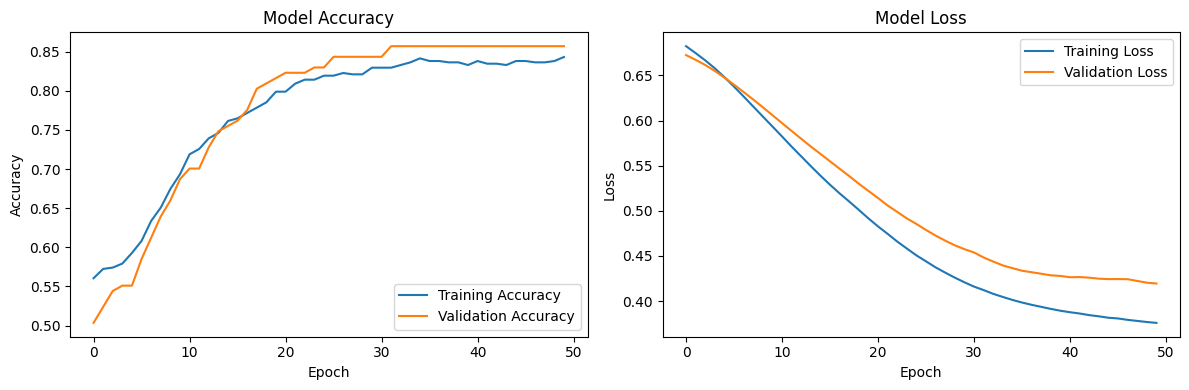

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

Test Accuracy: 0.7554

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.77      0.72        77
           1       0.82      0.75      0.78       107

    accuracy                           0.76       184
   macro avg       0.75      0.76      0.75       184
weighted avg       0.76      0.76      0.76       184



In [20]:
sgd_model = create_model(optimizer='sgd')
# Modell trainieren
history_sgd = sgd_model.fit(X_train, y_train,
                    epochs=50,
                    batch_size=32,
                    validation_split=0.2,
                    verbose=1)

# Modell evaluieren
test_loss_sgd, test_accuracy_sgd = sgd_model.evaluate(X_test, y_test)

# Trainingsverlauf visualisieren
plt.figure(figsize=(12, 4))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_sgd.history['accuracy'], label='Training Accuracy')
plt.plot(history_sgd.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history_sgd.history['loss'], label='Training Loss')
plt.plot(history_sgd.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Vorhersagen machen
y_pred_sgd = sgd_model.predict(X_test)
y_pred_classes_sgd = (y_pred_sgd > 0.5).astype(int)

# Confusion Matrix und Classification Report
print(f"\nTest Accuracy: {test_accuracy_sgd:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes_sgd))

c:\Users\EBLEICT6P\vscode\maschinelles_lernen\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 64)             │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,521 (13.75 KB)

 Trainable params: 3,521 (13.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.6311 - loss: 0.6484 - val_accuracy: 0.8027 - val_loss: 0.5290
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8012 - loss: 0.4936 - val_accuracy: 0.8163 - val_loss: 0.4565
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7985 - loss: 0.4527 - val_accuracy: 0.8299 - val_loss: 0.4395
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8091 - loss: 0.4045 - val_accuracy: 0.8435 - val_loss: 0.4308
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8469 - loss: 0.3618 - val_accuracy: 0.8503 - val_loss: 0.4330
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8353 - loss: 0.3654 - val_accuracy: 0.8503 - val_loss: 0.4326
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8369 - loss: 0.3822 - val_accuracy: 0.8435 - val_loss: 0.4297
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8455 - loss: 0.3596 - val_accuracy: 0.8503 - val_los

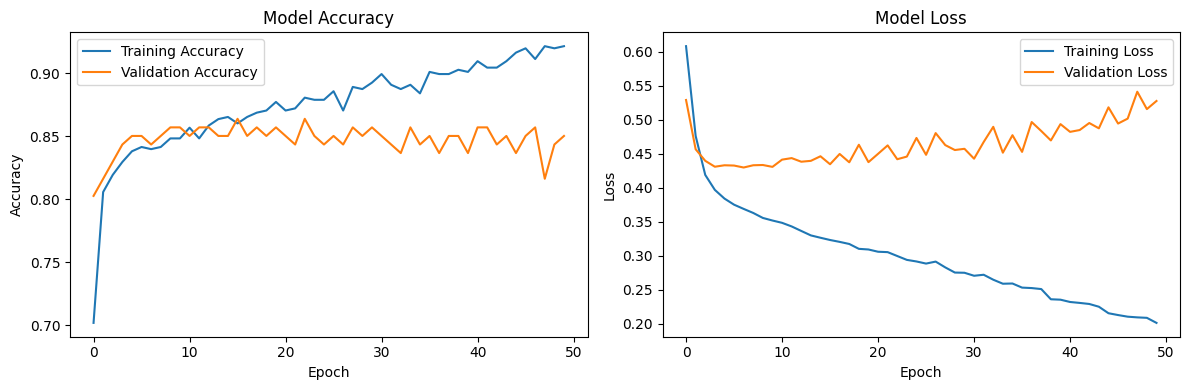

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

Test Accuracy: 0.7011

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.66      0.65        77
           1       0.75      0.73      0.74       107

    accuracy                           0.70       184
   macro avg       0.69      0.70      0.69       184
weighted avg       0.70      0.70      0.70       184



In [21]:
adam_model = create_model(optimizer='adam')
# Modell trainieren
history_adam = adam_model.fit(X_train, y_train,
                    epochs=50,
                    batch_size=32,
                    validation_split=0.2,
                    verbose=1)

# Modell evaluieren
test_loss, test_accuracy_adam = adam_model.evaluate(X_test, y_test)

# Trainingsverlauf visualisieren
plt.figure(figsize=(12, 4))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_adam.history['accuracy'], label='Training Accuracy')
plt.plot(history_adam.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history_adam.history['loss'], label='Training Loss')
plt.plot(history_adam.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Vorhersagen machen
y_pred_adam = adam_model.predict(X_test)
y_pred_classes_adam = (y_pred_adam > 0.5).astype(int)

# Confusion Matrix und Classification Report
print(f"\nTest Accuracy: {test_accuracy_adam:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes_adam))

## 4. Bedeutung der einzelnen Features

### 4.1 Feature-Bedeutung von PCA

In [22]:
feature_names = data.columns.tolist()
feature_names.remove("KHK") 
# Bedeutung der ursprünglichen Features
feature_importance = np.abs(pca.components_).sum(axis=0)
# DataFrame für Plotly erstellen
df_plot = pd.DataFrame({"Feature": feature_names, "Wichtigkeit": feature_importance})

# Interaktive Visualisierung mit Plotly
fig = px.bar(df_plot, x="Feature", y="Wichtigkeit", title="Feature-Bedeutung aus PCA", labels={"Feature": "Feature", "Wichtigkeit": "Feature-Wichtigkeit"})
fig.update_xaxes() 
fig.show()